## <center> SVI Jump Wings</center>

$$ w(k, X_R) = a + b\{\rho(k - m) + \sqrt{(k - m)^2 + \sigma^2} \}$$

$$ v_t = \frac{a + b\{-\rho m + \sqrt{m^2 + \sigma^2} \}}{T} $$

$$ \psi_t = \frac{b}{2\sqrt{v_t T}} (-\frac{m}{\sqrt{m^2 + \sigma^2}} + \rho)$$

$$ p_t = \frac{b(1 - \rho)}{\sqrt{v_t T}} $$

$$ c_t = \frac{b(1 + \rho)}{\sqrt{v_t T}} $$

$$ \tilde{v_t} = \frac{a + b\sigma \sqrt{1 - \rho^2})}{T} $$

Reconvert:

$$ b = \frac{\sqrt{v_t T} (c_t + p_t)}{2} $$
$$ \rho = 1 - \frac{p_t\sqrt{v_t T}}{b} $$
$$ \beta = \rho - \frac{2 \psi_t \sqrt{v_t T}}{b} $$
$$ \alpha = sign{\beta} \sqrt{\frac{1}{\beta^2} -1}$$
$$ m = \frac{(v_t-\tilde{v_t})T}{b(-\rho + sign(\alpha)\sqrt{1+\alpha^2}-\alpha\sqrt{1-\rho^2})} $$

$$ \sigma = \begin{cases}
      \frac{(\tilde{v_t}   - v_t) T }{b(\sqrt{1 - \rho^2} - 1)} , m = 0 \\
      m \alpha , other
    \end{cases} $$
    
$$ a = \tilde{v_t} T  - b \sigma \sqrt{1 - \rho^2} $$

$$ \sigma = \max(\sigma, 0) $$


Производные по параметрам в raw калибровке

In [1]:
import sympy as sym

In [2]:
a, b, rho, m, sigma, f, K, T = sym.symbols('a b rho m sigma f K T')
k = sym.log(K/f)
w = a + b *(rho*(k - m) + sym.sqrt((k-m)**2 + sigma**2))

In [3]:
#delta
w.diff(f).subs(k, "k")

b*(-rho/f - (k - m)/(f*sqrt(sigma**2 + (k - m)**2)))

In [4]:
#gamma
w.diff(f).diff(f).subs(k, "k")

b*(rho/f**2 - (k - m)**2/(f**2*(sigma**2 + (k - m)**2)**(3/2)) + (k - m)/(f**2*sqrt(sigma**2 + (k - m)**2)) + 1/(f**2*sqrt(sigma**2 + (k - m)**2)))

In [5]:
# a
w.diff(a).subs(k, "k")

1

In [6]:
# b
w.diff(b).subs(k, "k")

rho*(k - m) + sqrt(sigma**2 + (k - m)**2)

In [7]:
# rho
w.diff(rho).subs(k, "k")

b*(k - m)

In [8]:
# m
w.diff(m).subs(k, "k")

b*(-rho + (-k + m)/sqrt(sigma**2 + (k - m)**2))

In [9]:
# sigma
w.diff(sigma).subs(k, "k")

b*sigma/sqrt(sigma**2 + (k - m)**2)

 ##  <center> Калибровка </center> 

In [10]:
from importlib import reload
import pyquant.svi
reload(pyquant.svi)

from pyquant.svi import *
from pyquant.common import *
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd

import itertools
from scipy.stats import norm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 1000)
%matplotlib inline

In [11]:
bs_calc = BSCalc()

strikes = np.array([1300., 1400, 1500, 1600, 1700, 1800., 1900, 2000, 2100, 2200])
call_strikes = np.array([1800., 1900, 2000, 2100, 2200])
tau = 0.01
F = 1723.75
pvs = np.array([ 1.72375, 1.72375, 3.4475, 6.895, 26.718125, 11.204375,
                4.309375, 1.72375, 0.861875, 0.861875])

implied_vols = bs_calc.implied_vols(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)), 
    Strikes(strikes),
    Premiums(pvs)
).data

vol_smile_chain = VolSmileChain(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(implied_vols)
)
weights = CalibrationWeights(np.ones_like(vol_smile_chain.Ks))



In [12]:
svi_calc = SVICalc()

In [13]:
calibrated_params = svi_calc.calibrate(vol_smile_chain, weights)

/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:403: RuntimeWarning: invalid value encountered in sqrt
  denominator = 2 * np.sqrt(T * w)
/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:370: RuntimeWarning: invalid value encountered in sqrt
  iv = np.sqrt(w / T)


In [14]:
calibrated_params.array()

array([-0.05516348,  0.19508255, -0.53059706, -0.22331506,  0.35125428])

In [15]:
svi_calc.calibration_error

1.4068043478413755e-05

In [16]:
svi_calc.raw_cached_params

array([-0.05516348,  0.19508255, -0.53059706, -0.22331506,  0.35125428])

In [17]:
svi_calc.jump_wing_cached_params

array([0.292075  , 0.0106822 , 5.52499778, 1.69440429, 0.29187617])

In [18]:
test_strikes = Strikes(np.linspace(strikes[0], strikes[-1], 100))

In [19]:
test_iv = svi_calc.implied_vols(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    calibrated_params
)

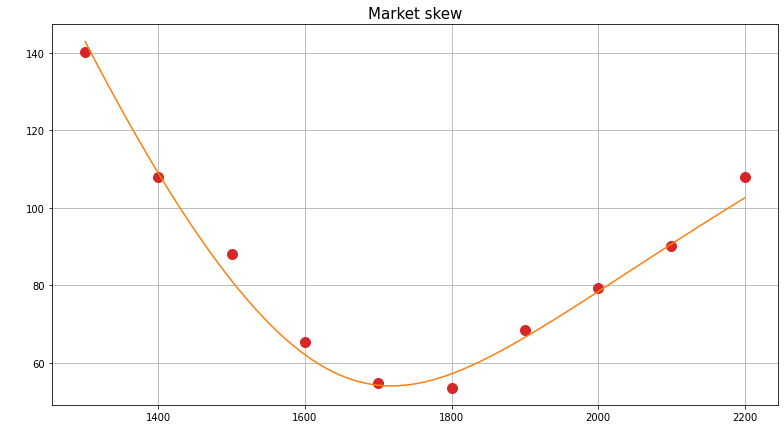

In [20]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

#### Warm starting

In [21]:
new_forward = 1723.25
new_pvs = np.array([ 0.861625,  1.72325 ,  3.4465  ,  6.893   , 26.710375,
                    11.201125,  4.308125,  1.72325 ,  1.72325 ,  0.861625])

In [22]:
new_implied_vols = bs_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    Premiums(new_pvs)
).data

In [23]:
new_vol_smile_chain = VolSmileChain(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(new_implied_vols)
)

In [24]:
svi_calc.cached_params = calibrated_params.array()

In [25]:
new_calibrated_params = svi_calc.calibrate(new_vol_smile_chain,  weights)
print(svi_calc.calibration_error)
new_calibrated_params.array()

6.0128917261860604e-06


array([-0.01094361,  0.08051245, -0.00554534,  0.01066677,  0.172677  ])

#### BSM limit

In [26]:
flat_implied_vols = np.ones_like(implied_vols)*0.8
flat_vol_smile_chain = VolSmileChain(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(flat_implied_vols)
)
svi_calc.update_raw_cached_params(
    SVIRawParams(A(100.0), B(1.0), Rho(0.0), M(1.0), Sigma(1.0))
)
flat_calibrated_params = svi_calc.calibrate(flat_vol_smile_chain,  weights)
print(svi_calc.calibration_error)
flat_calibrated_params.array()

8.326443965321616e-09


/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:403: RuntimeWarning: invalid value encountered in sqrt
  denominator = 2 * np.sqrt(T * w)
/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:370: RuntimeWarning: invalid value encountered in sqrt
  iv = np.sqrt(w / T)


array([ 6.41282966e-03,  1.00000000e-04, -9.99900000e-01, -2.35533478e+01,
        1.00000000e-04])

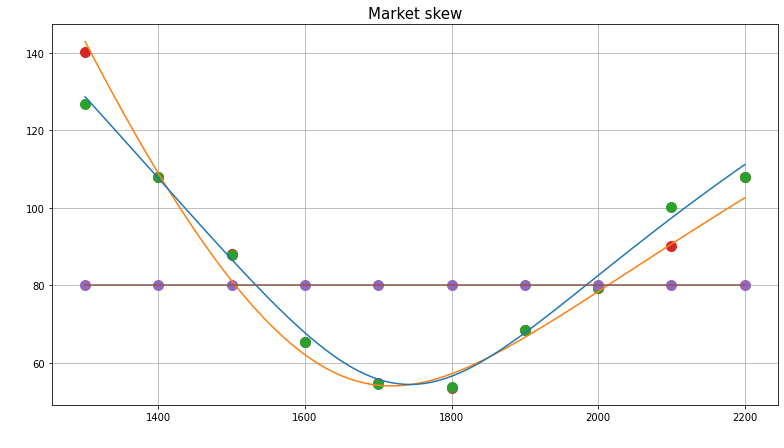

In [27]:
flat_test_iv = svi_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    flat_calibrated_params
)
new_test_iv = svi_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    new_calibrated_params
)
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(strikes, 100*new_implied_vols, '.C2', markersize=20)
plt.plot(strikes, 100*flat_implied_vols, '.C4', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.plot(test_strikes.data, 100*new_test_iv.data, 'C0')
plt.plot(test_strikes.data, 100*flat_test_iv.data, 'C5')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()